In [ ]:
import psi4
from qcportal import PortalClient
from pprint import pprint as pp
from qcelemental.models import Molecule
import qcelemental as qcel
from qcportal.singlepoint import SinglepointDataset, SinglepointDatasetEntry, QCSpecification
import pandas as pd
import numpy as np
import re
from qm_tools_aw import tools

# need manybodydataset
from qcportal.manybody import ManybodyDataset, ManybodyDatasetEntry, ManybodyDatasetSpecification, ManybodySpecification
from pprint import pprint as pp

In [1]:
from setup_qcfractal import setup_qcarchive_qcfractal
import os

setup_qcarchive_qcfractal(
    QCF_BASE_FOLDER=os.path.join(os.getcwd(), "qcfractal"),
    start=False,
    reset=False,
    db_config={
        "name": None,
        "enable_security": "false",
        "allow_unauthenticated_read": None,
        "logfile": None,
        "loglevel": None,
        "service_frequency": 5,
        "max_active_services": None,
        "heartbeat_frequency": 60,
        "log_access": None,
        "database": {
            "base_folder": None,
            "host": None,
            "port": 5432,
            "database_name": "qca",
            "username": None,
            "password": None,
            "own": None,
        },
        "api": {
            "host": None,
            "port": 7777,
            "secret_key": None,
            "jwt_secret_key": None,
        },
    },
    resources_config={
            "update_frequency": 5,
            "cores_per_worker": 8,
            "max_workers": 3,
            "memory_per_worker": 20,
    }
)

/home/amwalla3/gits/cybershuttle_demo/qcfractal

--------------------------------------------------------------------------------
Python executable:  /home/amwalla3/miniconda3/envs/p4_qcml/bin/python
QCFractal version:  0.59
QCFractal alembic revision:  d5988aa750ae
pg_ctl path:  /home/amwalla3/miniconda3/envs/p4_qcml/bin/pg_ctl
PostgreSQL server version:  PostgreSQL 17.4 on x86_64-conda-linux-gnu, compiled by x86_64-conda-linux-gnu-cc (conda-forge gcc 13.3.0-2) 13.3.0, 64-bit
--------------------------------------------------------------------------------


Displaying QCFractal configuration below
--------------------------------------------------------------------------------
access_log_keep: 0
allow_unauthenticated_read: true
api:
  extra_flask_options: null
  extra_waitress_options: null
  host: localhost
  jwt_access_token_expires: 3600
  jwt_refresh_token_expires: 86400
  jwt_secret_key: Ndayk_pQFD3Cv1yjD79dEhzquQBG3BaL7K1BgP1qJp4
  num_threads_per_worker: 4
  port: 7777
  secret

In [ ]:
!qcfractal-server --config=`pwd`/qcfractal/qcfractal_config.yaml start > qcfractal_server.log & disown

# NOTE kill server when finished by running:
#     ps aux | grep qcfractal-server | awk '{ print $2 }'
#     kill -9 <PID>

In [ ]:
!qcfractal-compute-manager --config=`pwd`/qcfractal/resources.yml > qcfractal_compute.log & disown
# NOTE kill server when finished by running:;
#    ps aux | grep qcfractal-server | awk '{ print $2 }'
#    kill -9 <PID>

In [2]:
# Running a single job
client = PortalClient("http://localhost:7777", verify=False)
# for rec in client.query_records():
#     pp(rec)

mol = Molecule.from_data(
    """
     0 1
     O  -1.551007  -0.114520   0.000000
     H  -1.934259   0.762503   0.000000
     H  -0.599677   0.040712   0.000000
     --
     0 1
     O   1.350625   0.111469   0.000000
     H   1.680398  -0.373741  -0.758561
     H   1.680398  -0.373741   0.758561

     units angstrom
     no_reorient
     symmetry c1
"""
)

psi4.set_options(
    {"basis": "aug-cc-pvdz", "scf_type": "df", "e_convergence": 6, "freeze_core": True}
)

client.add_singlepoints(
    [mol],
    "psi4",
    driver="energy",
    method="b3lyp",
    basis="aug-cc-pvdz",
    keywords={"scf_type": "df", "e_convergence": 6, "freeze_core": True},
    tag="local",
)

# for rec in client.query_records():
#     pp(rec.dict)
#     pp(rec.error)

(InsertMetadata(error_description=None, errors=[], inserted_idx=[], existing_idx=[0]),
 [1])

In [3]:
# Now create S22 Interaction Energy Dataset
from s22 import geoms, ref_IEs

assert len(geoms) == len(ref_IEs), "Number of geometries and reference interaction energies do not match"

# geoms is a list of qcelemental Molecule objects that can be used to create a
# QCArchive dataset
print(len(geoms), geoms)

22 [Molecule(name='H6N2', formula='H6N2', hash='3fadb04'), Molecule(name='H4O2', formula='H4O2', hash='49ecd61'), Molecule(name='C2H4O4', formula='C2H4O4', hash='cb6a49d'), Molecule(name='C2H6N2O2', formula='C2H6N2O2', hash='b1ca3e5'), Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='13c83b3'), Molecule(name='C10H11N3O', formula='C10H11N3O', hash='3b8e723'), Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='3520f9b'), Molecule(name='C2H8', formula='C2H8', hash='67d7d29'), Molecule(name='C4H8', formula='C4H8', hash='47f28b2'), Molecule(name='C7H10', formula='C7H10', hash='4810149'), Molecule(name='C12H12', formula='C12H12', hash='420be36'), Molecule(name='C8H8N4', formula='C8H8N4', hash='3072d92'), Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='9f67f10'), Molecule(name='C14H13N', formula='C14H13N', hash='00ea319'), Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='4af63d5'), Molecule(name='C4H6', formula='C4H6', hash='2f8f067'), Molecule(name='C6H8O', formula='C6H8O'

In [4]:
# Create client dataset

ds_name = 'S22-multipoles'

try:
    ds = client.add_dataset("singlepoint", ds_name,
                            f"Dataset to contain {ds_name}")
    print(f"Added {ds_name} as dataset")
    # Insert entries into dataset
    entry_list = []
    for idx, mol in enumerate(geoms):
        extras = {
            "name": 'S22-' + str(idx),
            "idx": idx,
        }
        mol = Molecule.from_data(mol.dict(), extras=extras)
        ent = SinglepointDatasetEntry(name=extras['name'], molecule=mol)
        entry_list.append(ent)
    ds.add_entries(entry_list)
    print(f"Added {len(entry_list)} molecules to dataset")
except Exception:
    ds = client.get_dataset("singlepoint", ds_name)
    print(f"Found {ds_name} dataset, using this instead")
    print(ds)

Found S22-multipoles dataset, using this instead
id=1 dataset_type='singlepoint' name='S22-multipoles' description='Dataset to contain S22-multipoles' tagline='' tags=[] group='default' visibility=True provenance={} default_tag='*' default_priority=<PriorityEnum.normal: 1> owner_user=None owner_group=None metadata={} extras={} contributed_values_=None attachments_=None auto_fetch_missing=True


In [5]:
# Set the method and basis for lower requirements?
method, basis = "hf", "sto-3g"

# Set the QCSpecification (QM interaction energy in our case)
spec = QCSpecification(
    program="psi4",
    driver="energy",
    method=method,
    basis=basis,
    keywords={
        "d_convergence": 8,
        "dft_radial_points": 99,
        "dft_spherical_points": 590,
        "e_convergence": 10,
        "guess": "sad",
        "mbis_d_convergence": 9,
        "mbis_radial_points": 99,
        "mbis_spherical_points": 590,
        "scf_properties": ["mbis_charges", "MBIS_VOLUME_RATIOS"],
        "scf_type": "df",
    },
    protocols={"wavefunction": "orbitals_and_eigenvalues"},
)
ds.add_specification(name=f"psi4/{method}/{basis}", specification=spec)

InsertMetadata(error_description=None, errors=[], inserted_idx=[], existing_idx=[0])

In [6]:
# Set the method and basis for lower requirements?
method, basis = "SAPT0", "cc-pvdz"

# Set the QCSpecification (QM interaction energy in our case)
spec = QCSpecification(
    program="psi4",
    driver="energy",
    method=method,
    basis=basis,
    keywords={
        "scf_type": "df",
    },
)
ds.add_specification(name=f"psi4/{method}/{basis}", specification=spec)

InsertMetadata(error_description=None, errors=[], inserted_idx=[], existing_idx=[0])

In [7]:
# Run the computations
ds.submit()
print(f"Submitted {ds_name} dataset")

Submitted S22-multipoles dataset


In [8]:
# Check the status of the dataset - can repeatedly run this to see the progress
ds.status()

{'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/SAPT0/cc-pvdz': {<RecordStatusEnum.complete: 'complete'>: 22}}

In [9]:
# Create client dataset

ds_name_mb = 'S22-manybody'

try:
    ds_mb = client.add_dataset("manybody", ds_name_mb,
                            f"Dataset to contain {ds_name_mb}")
    print(f"Added {ds_name_mb} as dataset")
except Exception:
    ds_mb = client.get_dataset("manybody", ds_name_mb)
    print(f"Found {ds_name_mb} dataset, using this instead")
    print(ds)

# Insert entries into dataset

entry_list = []
for idx, mol in enumerate(geoms):
    print(mol)
    ent = ManybodyDatasetEntry(name=f"S22-IE-{idx}", initial_molecule=mol)
    entry_list.append(ent)
ds_mb.add_entries(entry_list)
print(f"Added {len(entry_list)} molecules to dataset")

# Set the method and basis for lower requirements?
method, basis = "hf", "sto-3g"

# Set the QCSpecification (QM interaction energy in our case)

qc_spec_mb = QCSpecification(
    program="psi4",
    driver="energy",
    method=method,
    basis=basis,
    keywords={
        "d_convergence": 8,
        "scf_type": "df",
    },
)

spec_mb = ManybodySpecification(
    program='qcmanybody',
    bsse_correction=['cp', 'nocp'],
    levels={
        1: qc_spec_mb,
        2: qc_spec_mb,
    },
)
print("spec_mb", spec_mb)

ds_mb.add_specification(name=f"psi4/{method}/{basis}", specification=spec_mb)

# Run the computations
ds_mb.submit()
print(f"Submitted {ds_name} dataset")

# Check the status of the dataset - can repeatedly run this to see the progress
ds_mb.status()

Found S22-manybody dataset, using this instead
id=1 dataset_type='singlepoint' name='S22-multipoles' description='Dataset to contain S22-multipoles' tagline='' tags=[] group='default' visibility=True provenance={} default_tag='*' default_priority=<PriorityEnum.normal: 1> owner_user=None owner_group=None metadata={} extras={} contributed_values_=None attachments_=None auto_fetch_missing=True
Molecule(name='H6N2', formula='H6N2', hash='3fadb04')
Molecule(name='H4O2', formula='H4O2', hash='49ecd61')
Molecule(name='C2H4O4', formula='C2H4O4', hash='cb6a49d')
Molecule(name='C2H6N2O2', formula='C2H6N2O2', hash='b1ca3e5')
Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='13c83b3')
Molecule(name='C10H11N3O', formula='C10H11N3O', hash='3b8e723')
Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='3520f9b')
Molecule(name='C2H8', formula='C2H8', hash='67d7d29')
Molecule(name='C4H8', formula='C4H8', hash='47f28b2')
Molecule(name='C7H10', formula='C7H10', hash='4810149')
Molecule(name='C12H12'

{'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/b3lyp/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22}}

In [10]:
ds_mb.status()

{'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/b3lyp/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22}}

In [11]:
# Want multiple levels of theory

methods = [
    'hf', 'pbe', 'b3lyp',
]
basis_sets = [
    '6-31g*'
]

for method in methods:
    for basis in basis_sets:
        # Set the QCSpecification (QM interaction energy in our case)
        qc_spec_mb = QCSpecification(
            program="psi4",
            driver="energy",
            method=method,
            basis=basis,
            keywords={
                "d_convergence": 8,
                "scf_type": "df",
            },
        )

        spec_mb = ManybodySpecification(
            program='qcmanybody',
            bsse_correction=['cp'],
            levels={
                1: qc_spec_mb,
                2: qc_spec_mb,
            },
        )
        print("spec_mb", spec_mb)

        ds_mb.add_specification(name=f"psi4/{method}/{basis}", specification=spec_mb)

        # Run the computations
        ds_mb.submit()
        print(f"Submitted {ds_name} dataset")
# Check the status of the dataset - can repeatedly run this to see the progress
ds_mb.status()

spec_mb program='qcmanybody' levels={1: QCSpecification(program='psi4', driver=<SinglepointDriver.energy: 'energy'>, method='hf', basis='6-31g*', keywords={'d_convergence': 8, 'scf_type': 'df'}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>)), 2: QCSpecification(program='psi4', driver=<SinglepointDriver.energy: 'energy'>, method='hf', basis='6-31g*', keywords={'d_convergence': 8, 'scf_type': 'df'}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>))} bsse_correction=[<BSSECorrectionEnum.cp: 'cp'>] keywords=ManybodyKeywords(return_total_data=False) protocols={}
Submitted S22-multipoles dataset
spec_mb program='qcmanybody' levels={1

{'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/b3lyp/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22}}

In [12]:
pp(ds.status())
pp(ds_mb.status())

{'psi4/SAPT0/cc-pvdz': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22}}
{'psi4/b3lyp/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22}}


In [13]:
pp(ds)
pp(ds_mb)
pp(ds_mb.computed_properties)
# client.delete_dataset(dataset_id=2, delete_records=True)

SinglepointDataset(id=1, dataset_type='singlepoint', name='S22-multipoles', description='Dataset to contain S22-multipoles', tagline='', tags=[], group='default', visibility=True, provenance={}, default_tag='*', default_priority=<PriorityEnum.normal: 1>, owner_user=None, owner_group=None, metadata={}, extras={}, contributed_values_=None, attachments_=None, auto_fetch_missing=True)
ManybodyDataset(id=2, dataset_type='manybody', name='S22-manybody', description='Dataset to contain S22-manybody', tagline='', tags=[], group='default', visibility=True, provenance={}, default_tag='*', default_priority=<PriorityEnum.normal: 1>, owner_user=None, owner_group=None, metadata={}, extras={}, contributed_values_=None, attachments_=None, auto_fetch_missing=True)
{'psi4/b3lyp/6-31g*': ['results',
                       'mc_results',
                       'ret_energy',
                       'energy_body_dict',
                       'component_properties'],
 'psi4/hf/6-31g*': ['results',
            

In [14]:
# Multipole Molecule assemble
def assemble_multipole_data(record):
    record_dict = record.dict()
    qcvars = record_dict["properties"]
    level_of_theory = f"{record_dict['specification']['method']}/{record_dict['specification']['basis']}"
    sapt_energies = np.array([np.nan, np.nan, np.nan, np.nan, np.nan])
    if "mbis charges" in qcvars:
        charges = qcvars["mbis charges"]
        dipoles = qcvars["mbis dipoles"]
        quadrupoles = qcvars["mbis quadrupoles"]
        n = len(charges)
        charges = np.reshape(charges, (n, 1))
        dipoles = np.reshape(dipoles, (n, 3))
        quad = np.reshape(quadrupoles, (n, 3, 3))

        quad = [q[np.triu_indices(3)] for q in quad]
        quadrupoles = np.array(quad)
        multipoles = np.concatenate(
            [charges, dipoles, quadrupoles], axis=1)
        return (
        record.molecule,
        qcvars['mbis volume ratios'],
        qcvars['mbis valence widths'],
        qcvars['mbis radial moments <r^2>'],
        qcvars['mbis radial moments <r^3>'],
        qcvars['mbis radial moments <r^4>'],
        record.molecule.atomic_numbers,
        record.molecule.geometry * qcel.constants.bohr2angstroms,
        multipoles,
        int(record.molecule.molecular_charge),
        record.molecule.molecular_multiplicity,
        sapt_energies,
        )
    else:
        sapt_energies[0] = qcvars['sapt total energy']
        sapt_energies[1] = qcvars['sapt elst energy']
        sapt_energies[2] = qcvars['sapt exch energy']
        sapt_energies[3] = qcvars['sapt ind energy']
        sapt_energies[4] = qcvars['sapt disp energy']
        # pp(record_dict)
        return (
        record.molecule,
        None,
        None,
        None,
        None,
        None,
        record.molecule.atomic_numbers,
        record.molecule.geometry * qcel.constants.bohr2angstroms,
        None,
        int(record.molecule.molecular_charge),
        record.molecule.molecular_multiplicity,
        sapt_energies,
        )




def assemble_multipole_data_value_names():
    return [
        'qcel_molecule',
        "volume ratios",
        "valence widths",
        "radial moments <r^2>",
        "radial moments <r^3>",
        "radial moments <r^4>",
        "Z",
        "R",
        "cartesian_multipoles",
        "TQ",
        "molecular_multiplicity",
        "SAPT Energies"
    ]

df = ds.compile_values(
    value_call=assemble_multipole_data,
    value_names=assemble_multipole_data_value_names(),
    unpack=True,
)
# print(df)
pp(df.columns.tolist())
print(df['psi4/hf/sto-3g'])
pp(df['psi4/hf/sto-3g'].columns.tolist())
df_sapt0 = df['psi4/SAPT0/cc-pvdz']
print(df_sapt0.columns.tolist())
print(df_sapt0)

[('psi4/SAPT0/cc-pvdz', 'qcel_molecule'),
 ('psi4/hf/sto-3g', 'qcel_molecule'),
 ('psi4/SAPT0/cc-pvdz', 'volume ratios'),
 ('psi4/hf/sto-3g', 'volume ratios'),
 ('psi4/SAPT0/cc-pvdz', 'valence widths'),
 ('psi4/hf/sto-3g', 'valence widths'),
 ('psi4/SAPT0/cc-pvdz', 'radial moments <r^2>'),
 ('psi4/hf/sto-3g', 'radial moments <r^2>'),
 ('psi4/SAPT0/cc-pvdz', 'radial moments <r^3>'),
 ('psi4/hf/sto-3g', 'radial moments <r^3>'),
 ('psi4/SAPT0/cc-pvdz', 'radial moments <r^4>'),
 ('psi4/hf/sto-3g', 'radial moments <r^4>'),
 ('psi4/SAPT0/cc-pvdz', 'Z'),
 ('psi4/hf/sto-3g', 'Z'),
 ('psi4/SAPT0/cc-pvdz', 'R'),
 ('psi4/hf/sto-3g', 'R'),
 ('psi4/SAPT0/cc-pvdz', 'cartesian_multipoles'),
 ('psi4/hf/sto-3g', 'cartesian_multipoles'),
 ('psi4/SAPT0/cc-pvdz', 'TQ'),
 ('psi4/hf/sto-3g', 'TQ'),
 ('psi4/SAPT0/cc-pvdz', 'molecular_multiplicity'),
 ('psi4/hf/sto-3g', 'molecular_multiplicity'),
 ('psi4/SAPT0/cc-pvdz', 'SAPT Energies'),
 ('psi4/hf/sto-3g', 'SAPT Energies')]
                                  

In [15]:
h2kcalmol = qcel.constants.hartree2kcalmol

def assemble_data(record):
    record_dict = record.dict()
    qcvars = record_dict["properties"]
    level_of_theory = f"{record_dict['specification']['levels'][2]['method']}/{record_dict['specification']['levels'][2]['basis']}"
    CP_IE = qcvars['results']['cp_corrected_interaction_energy'] * h2kcalmol
    NOCP_IE = qcvars['results'].get('nocp_corrected_interaction_energy', np.nan) * h2kcalmol
    return (
    record.initial_molecule,
    CP_IE,
    NOCP_IE,
    record.initial_molecule.atomic_numbers,
    record.initial_molecule.geometry * qcel.constants.bohr2angstroms,
    int(record.initial_molecule.molecular_charge),
    record.initial_molecule.molecular_multiplicity,
    )

def assemble_data_value_names():
    return [
        'qcel_molecule',
        "CP_IE",
        "NOCP_IE",
        "Z",
        "R",
        "TQ",
        "molecular_multiplicity"
    ]

df_mb = ds_mb.compile_values(
    value_call=assemble_data,
    value_names=assemble_data_value_names(),
    unpack=True,
)

print(df_mb)

specification                                  psi4/b3lyp/6-31g*  ...        psi4/pbe/6-31g*
                                                   qcel_molecule  ... molecular_multiplicity
entry                                                             ...                       
S22-IE-0       Molecule(name='H6N2', formula='H6N2', hash='3f...  ...                      1
S22-IE-1       Molecule(name='H4O2', formula='H4O2', hash='49...  ...                      1
S22-IE-10      Molecule(name='C12H12', formula='C12H12', hash...  ...                      1
S22-IE-11      Molecule(name='C8H8N4', formula='C8H8N4', hash...  ...                      1
S22-IE-12      Molecule(name='C8H8N4O4', formula='C8H8N4O4', ...  ...                      1
S22-IE-13      Molecule(name='C14H13N', formula='C14H13N', ha...  ...                      1
S22-IE-14      Molecule(name='C10H11N7O2', formula='C10H11N7O...  ...                      1
S22-IE-15      Molecule(name='C4H6', formula='C4H6', hash='2f...  ... 

In [16]:
from cdsg_plot import error_statistics

pp(df_mb.columns.tolist())
print(len(df_sapt0))
print(len(df_sapt0['SAPT Energies']))
print(len(df_sapt0['SAPT Energies'].apply(lambda x: x[0] * h2kcalmol)))

df_sapt0['sapt0 total energes'] = df_sapt0['SAPT Energies'].apply(lambda x: x[0] * h2kcalmol)
print(df_sapt0['sapt0 total energes'])
df_plot = pd.DataFrame(
    {
        "qcel_molecule": df_mb["psi4/hf/sto-3g"]["qcel_molecule"],
        "HF/6-31G*": df_mb["psi4/hf/6-31g*"]["CP_IE"],
        "PBE/6-31G*": df_mb["psi4/pbe/6-31g*"]["CP_IE"],
        "B3LYP/6-31G*": df_mb["psi4/b3lyp/6-31g*"]["CP_IE"],
        'SAPT0/cc-pvdz': df_sapt0['sapt0 total energes'].values,
    }
)
print(df_plot)
id = [int(i[7:]) for i in df_plot.index]
df_plot['id'] = id
df_plot.sort_values(by='id', inplace=True, ascending=True)
df_plot['reference'] = ref_IEs
df_plot['HF/6-31G* error'] = (df_plot['HF/6-31G*'] - df_plot['reference']).astype(float)
df_plot['PBE/6-31G* error'] = (df_plot['PBE/6-31G*'] - df_plot['reference']).astype(float)
df_plot['B3LYP/6-31G* error'] = (df_plot['B3LYP/6-31G*'] - df_plot['reference']).astype(float)
df_plot['SAPT0/cc-pvdz error'] = (df_plot['SAPT0/cc-pvdz'] - df_plot['reference']).astype(float)
pd.set_option('display.max_rows', None)
print(df_plot)
print(df_plot[['HF/6-31G* error', 'PBE/6-31G* error', 'B3LYP/6-31G* error']].describe())

[('psi4/b3lyp/6-31g*', 'qcel_molecule'),
 ('psi4/hf/6-31g*', 'qcel_molecule'),
 ('psi4/hf/sto-3g', 'qcel_molecule'),
 ('psi4/pbe/6-31g*', 'qcel_molecule'),
 ('psi4/b3lyp/6-31g*', 'CP_IE'),
 ('psi4/hf/6-31g*', 'CP_IE'),
 ('psi4/hf/sto-3g', 'CP_IE'),
 ('psi4/pbe/6-31g*', 'CP_IE'),
 ('psi4/b3lyp/6-31g*', 'NOCP_IE'),
 ('psi4/hf/6-31g*', 'NOCP_IE'),
 ('psi4/hf/sto-3g', 'NOCP_IE'),
 ('psi4/pbe/6-31g*', 'NOCP_IE'),
 ('psi4/b3lyp/6-31g*', 'Z'),
 ('psi4/hf/6-31g*', 'Z'),
 ('psi4/hf/sto-3g', 'Z'),
 ('psi4/pbe/6-31g*', 'Z'),
 ('psi4/b3lyp/6-31g*', 'R'),
 ('psi4/hf/6-31g*', 'R'),
 ('psi4/hf/sto-3g', 'R'),
 ('psi4/pbe/6-31g*', 'R'),
 ('psi4/b3lyp/6-31g*', 'TQ'),
 ('psi4/hf/6-31g*', 'TQ'),
 ('psi4/hf/sto-3g', 'TQ'),
 ('psi4/pbe/6-31g*', 'TQ'),
 ('psi4/b3lyp/6-31g*', 'molecular_multiplicity'),
 ('psi4/hf/6-31g*', 'molecular_multiplicity'),
 ('psi4/hf/sto-3g', 'molecular_multiplicity'),
 ('psi4/pbe/6-31g*', 'molecular_multiplicity')]
22
22
22
entry
S22-0     -2.281698
S22-1     -4.830288
S22-10    -1.

Plotting S22-IE.png
S22-IE_violin.png


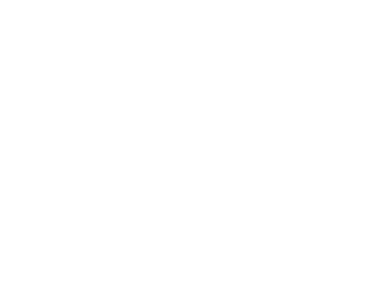

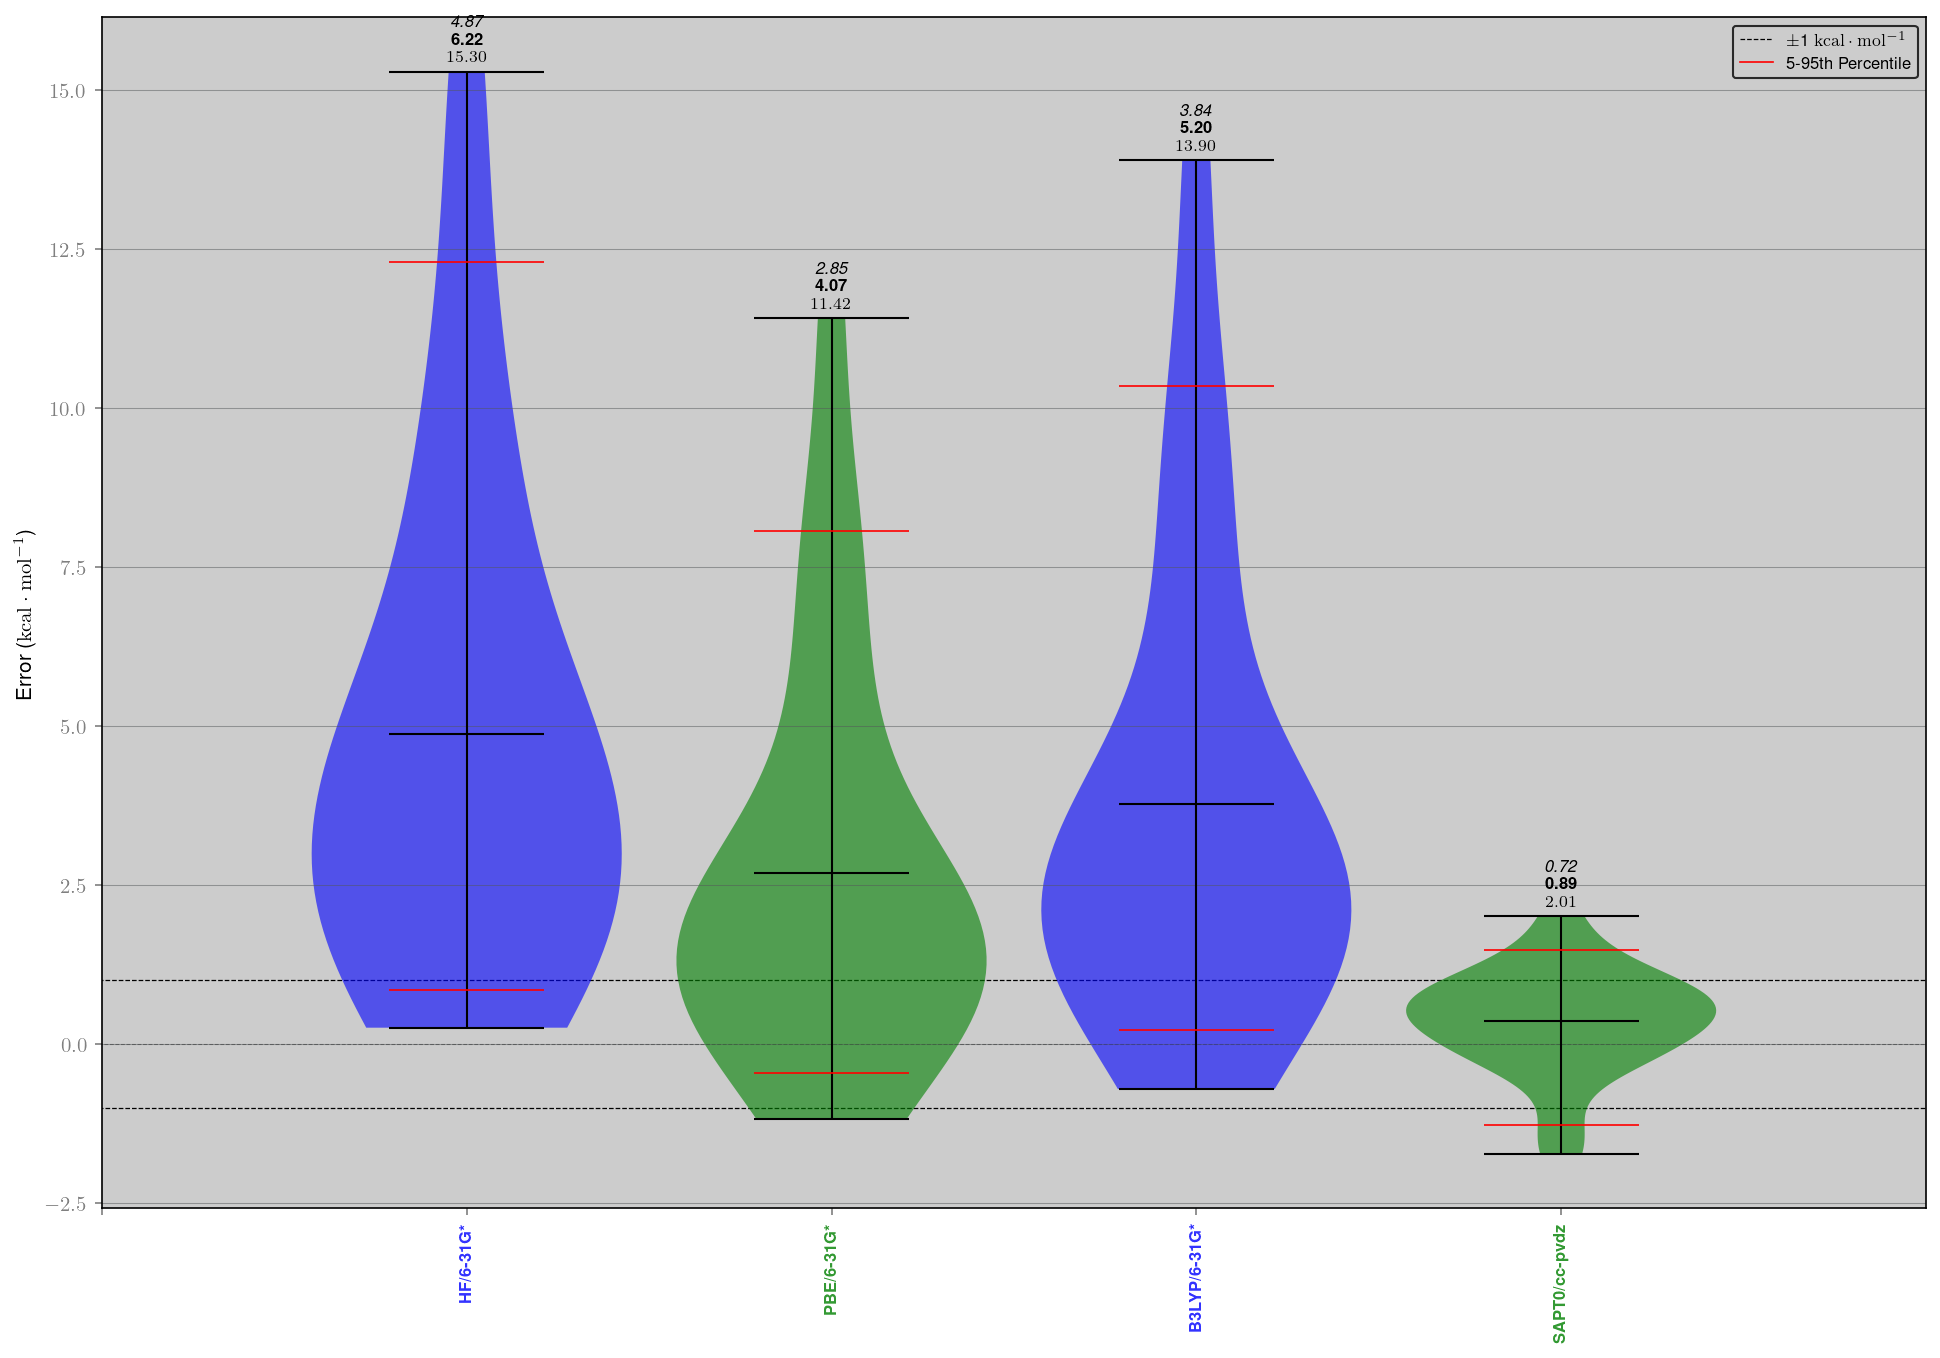

In [17]:
error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        "B3LYP/6-31G*": "B3LYP/6-31G* error",
        "SAPT0/cc-pvdz": "SAPT0/cc-pvdz error",
    },
    output_filename="S22-IE.png",
    figure_size=(8, 6),
)

In [18]:
import apnet_pt
from apnet_pt.AtomPairwiseModels.apnet2 import APNet2Model

ap2 = APNet2Model(dataset=ds2).set_pretrained_model(model_id=0)
apnet2_ies_predicted = ap2.predict_qcel_mols(
    mols=df_plot['qcel_molecule'].tolist(),
)

running on the CPU
self.dataset=apnet2_module_dataset(22)


              APNet2  reference PBE/6-31G*
entry                                     
S22-IE-0   -3.826870     -3.133  -3.620746
S22-IE-1   -5.548357     -4.989  -6.161219
S22-IE-2  -22.381687    -18.753 -18.091595
S22-IE-3  -17.419294    -16.062 -15.232638
S22-IE-4  -24.304586    -20.641 -18.574931
S22-IE-5  -18.312634    -16.934 -15.917838
S22-IE-6  -20.070183    -16.660 -14.567071
S22-IE-7   -0.574184     -0.527   0.018321
S22-IE-8   -1.805605     -1.472  -0.342497
S22-IE-9   -1.638113     -1.448   0.169368
S22-IE-10  -4.292087     -2.654   2.851358
S22-IE-11  -6.622308     -4.255   1.219997
S22-IE-12 -13.029117     -9.805  -1.957243
S22-IE-13  -7.068223     -4.524   3.553777
S22-IE-14 -16.016019    -11.730  -0.310899
S22-IE-15  -1.877746     -1.496   -1.46487
S22-IE-16  -4.095119     -3.275  -2.208023
S22-IE-17  -4.582874     -2.312  -0.930972
S22-IE-18  -6.737041     -4.541  -3.040681
S22-IE-19  -4.006771     -2.717  -0.038701
S22-IE-20  -7.319298     -5.627  -2.281689
S22-IE-21  

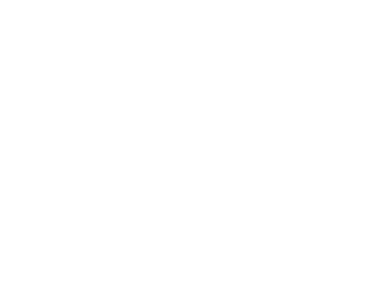

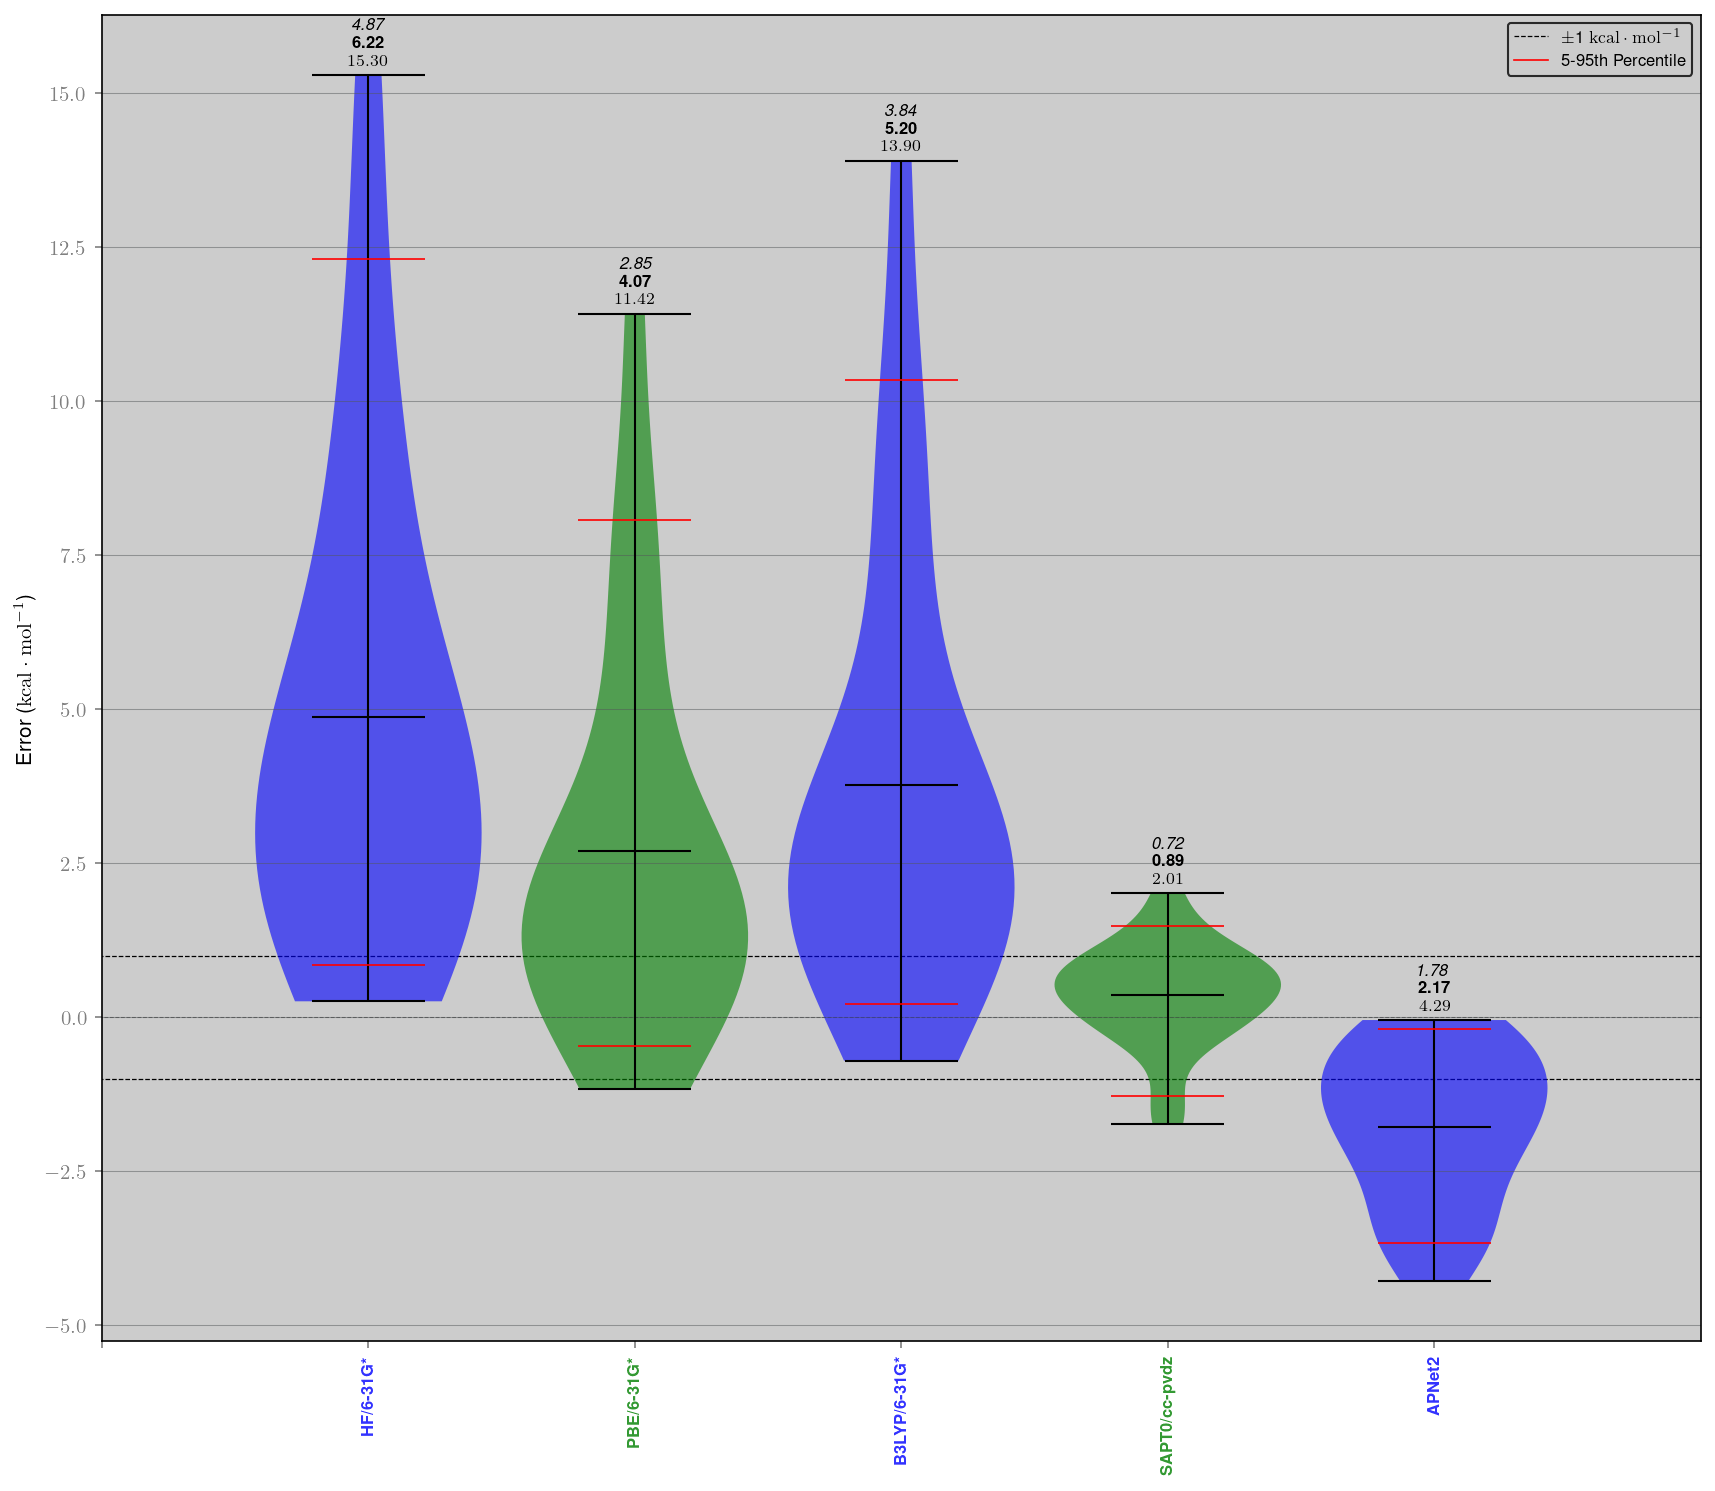

In [19]:
# AP-Net2 IE
df_plot['APNet2'] = np.sum(apnet2_ies_predicted, axis=1)
df_plot['APNet2 error'] = (df_plot['APNet2'] - df_plot['reference']).astype(float)
print(df_plot[['APNet2', 'reference', 'PBE/6-31G*']])
print(apnet2_ies_predicted)
error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        "B3LYP/6-31G*": "B3LYP/6-31G* error",
        "SAPT0/cc-pvdz": "SAPT0/cc-pvdz error",
        "APNet2": "APNet2 error",
    },
    output_filename="S22-IE-AP2.png",
    figure_size=(4, 4),
)

In [20]:
# Training models on new QM data for Transfer Learning Task

from apnet_pt import pairwise_datasets

print(
    df_plot['qcel_molecule'].tolist(),
    df_plot['PBE/6-31G*'].tolist(),
)
print(len(df_plot['qcel_molecule'].tolist()))

ds2 = pairwise_datasets.apnet2_module_dataset(
    root="data_dir",
    spec_type=None,
    atom_model=apnet_pt.AtomModels.ap2_atom_model.AtomModel().set_pretrained_model(model_id=0),
    qcel_molecules=df_plot['qcel_molecule'].tolist(),
    energy_labels=[np.array([i]) for i in df_plot['reference'].tolist()],
    skip_compile=True,
    force_reprocess=True,
    atomic_batch_size=8,
    prebatched=False,
    in_memory=True,
    batch_size=4,
    # datapoint_storage_n_objects=4,
)
print("APNet2 dataset created")
print(ds2)
# print(ds2.data)

[Molecule(name='H6N2', formula='H6N2', hash='3fadb04'), Molecule(name='H4O2', formula='H4O2', hash='49ecd61'), Molecule(name='C2H4O4', formula='C2H4O4', hash='cb6a49d'), Molecule(name='C2H6N2O2', formula='C2H6N2O2', hash='b1ca3e5'), Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='13c83b3'), Molecule(name='C10H11N3O', formula='C10H11N3O', hash='3b8e723'), Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='3520f9b'), Molecule(name='C2H8', formula='C2H8', hash='67d7d29'), Molecule(name='C4H8', formula='C4H8', hash='47f28b2'), Molecule(name='C7H10', formula='C7H10', hash='4810149'), Molecule(name='C12H12', formula='C12H12', hash='420be36'), Molecule(name='C8H8N4', formula='C8H8N4', hash='3072d92'), Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='9f67f10'), Molecule(name='C14H13N', formula='C14H13N', hash='00ea319'), Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='4af63d5'), Molecule(name='C4H6', formula='C4H6', hash='2f8f067'), Molecule(name='C6H8O', formula='C6H8O', h

In [21]:
# Transfer Learning APNet2 model on computed QM data
print(ds2)
ap2.train(
    n_epochs=2,
    transfer_learning=True,
    skip_compile=True,
    model_path="apnet2_transfer_learning.pt",
    split_percent=0.8,
)
print(ap2)

apnet2_module_dataset(22)
Saving training results to...
apnet2_transfer_learning.pt
~~ Training APNet2Model ~~
    Training on 17 samples, Testing on 5 samples

Network Hyperparameters:
  self.model.n_message=3
  self.model.n_neuron=128
  self.model.n_embed=8
  self.model.n_rbf=8
  self.model.r_cut=5.0
  self.model.r_cut_im=8.0

Training Hyperparameters:
  n_epochs=20
  lr=0.0005

  lr_decay=None

  batch_size=4
Running single-process training
                                       Total
  (Pre-training) (0.24   s)  MAE:   0.242/1.238  
  EPOCH:    0 (0.32   s)  MAE:   0.774/3.557    
  EPOCH:    1 (0.32   s)  MAE:   2.070/1.049   *
  EPOCH:    2 (0.33   s)  MAE:   1.384/1.368    
  EPOCH:    3 (0.31   s)  MAE:   1.696/1.575    
  EPOCH:    4 (0.32   s)  MAE:   1.043/1.291    
  EPOCH:    5 (0.32   s)  MAE:   1.120/1.680    
  EPOCH:    6 (0.32   s)  MAE:   0.820/1.681    
  EPOCH:    7 (0.32   s)  MAE:   0.505/1.537    
  EPOCH:    8 (0.32   s)  MAE:   0.531/1.544    
  EPOCH:    9 (0

running on the CPU
Loading pre-trained APNet2_MPNN model from apnet2_transfer_learning.pt
self.dataset=None
[[-4.61930513e+00  2.19648266e+00 -9.37234044e-01 -1.65587473e+00]
 [-5.07114506e+00  5.47395754e+00 -2.34430981e+00 -1.98542643e+00]
 [-2.96328773e+01  3.13376179e+01 -1.47811661e+01 -8.43996048e+00]
 [-2.66259251e+01  2.19158134e+01 -9.35370445e+00 -7.09381533e+00]
 [-3.64896126e+01  2.65054626e+01 -1.49591675e+01 -9.37090492e+00]
 [-3.10329723e+01  2.59994354e+01 -1.11364079e+01 -1.00146370e+01]
 [-3.04761391e+01  2.58979492e+01 -1.14344254e+01 -1.07595930e+01]
 [-3.15339863e-02  5.32630265e-01 -2.51703709e-01 -9.66526151e-01]
 [-2.24074054e+00  2.87737346e+00 -6.92645133e-01 -2.61621904e+00]
 [-8.72946024e-01  1.85793483e+00 -1.44437802e+00 -3.19937372e+00]
 [-4.86704111e+00  7.79753256e+00 -3.14014840e+00 -1.20084620e+01]
 [-6.80511951e+00  7.85842609e+00 -2.86567926e+00 -1.22532082e+01]
 [-1.18291407e+01  9.24298000e+00 -3.57079887e+00 -1.37545586e+01]
 [-7.54318237e+00  1.

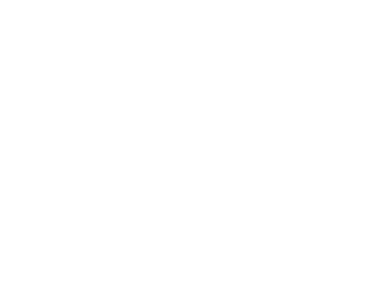

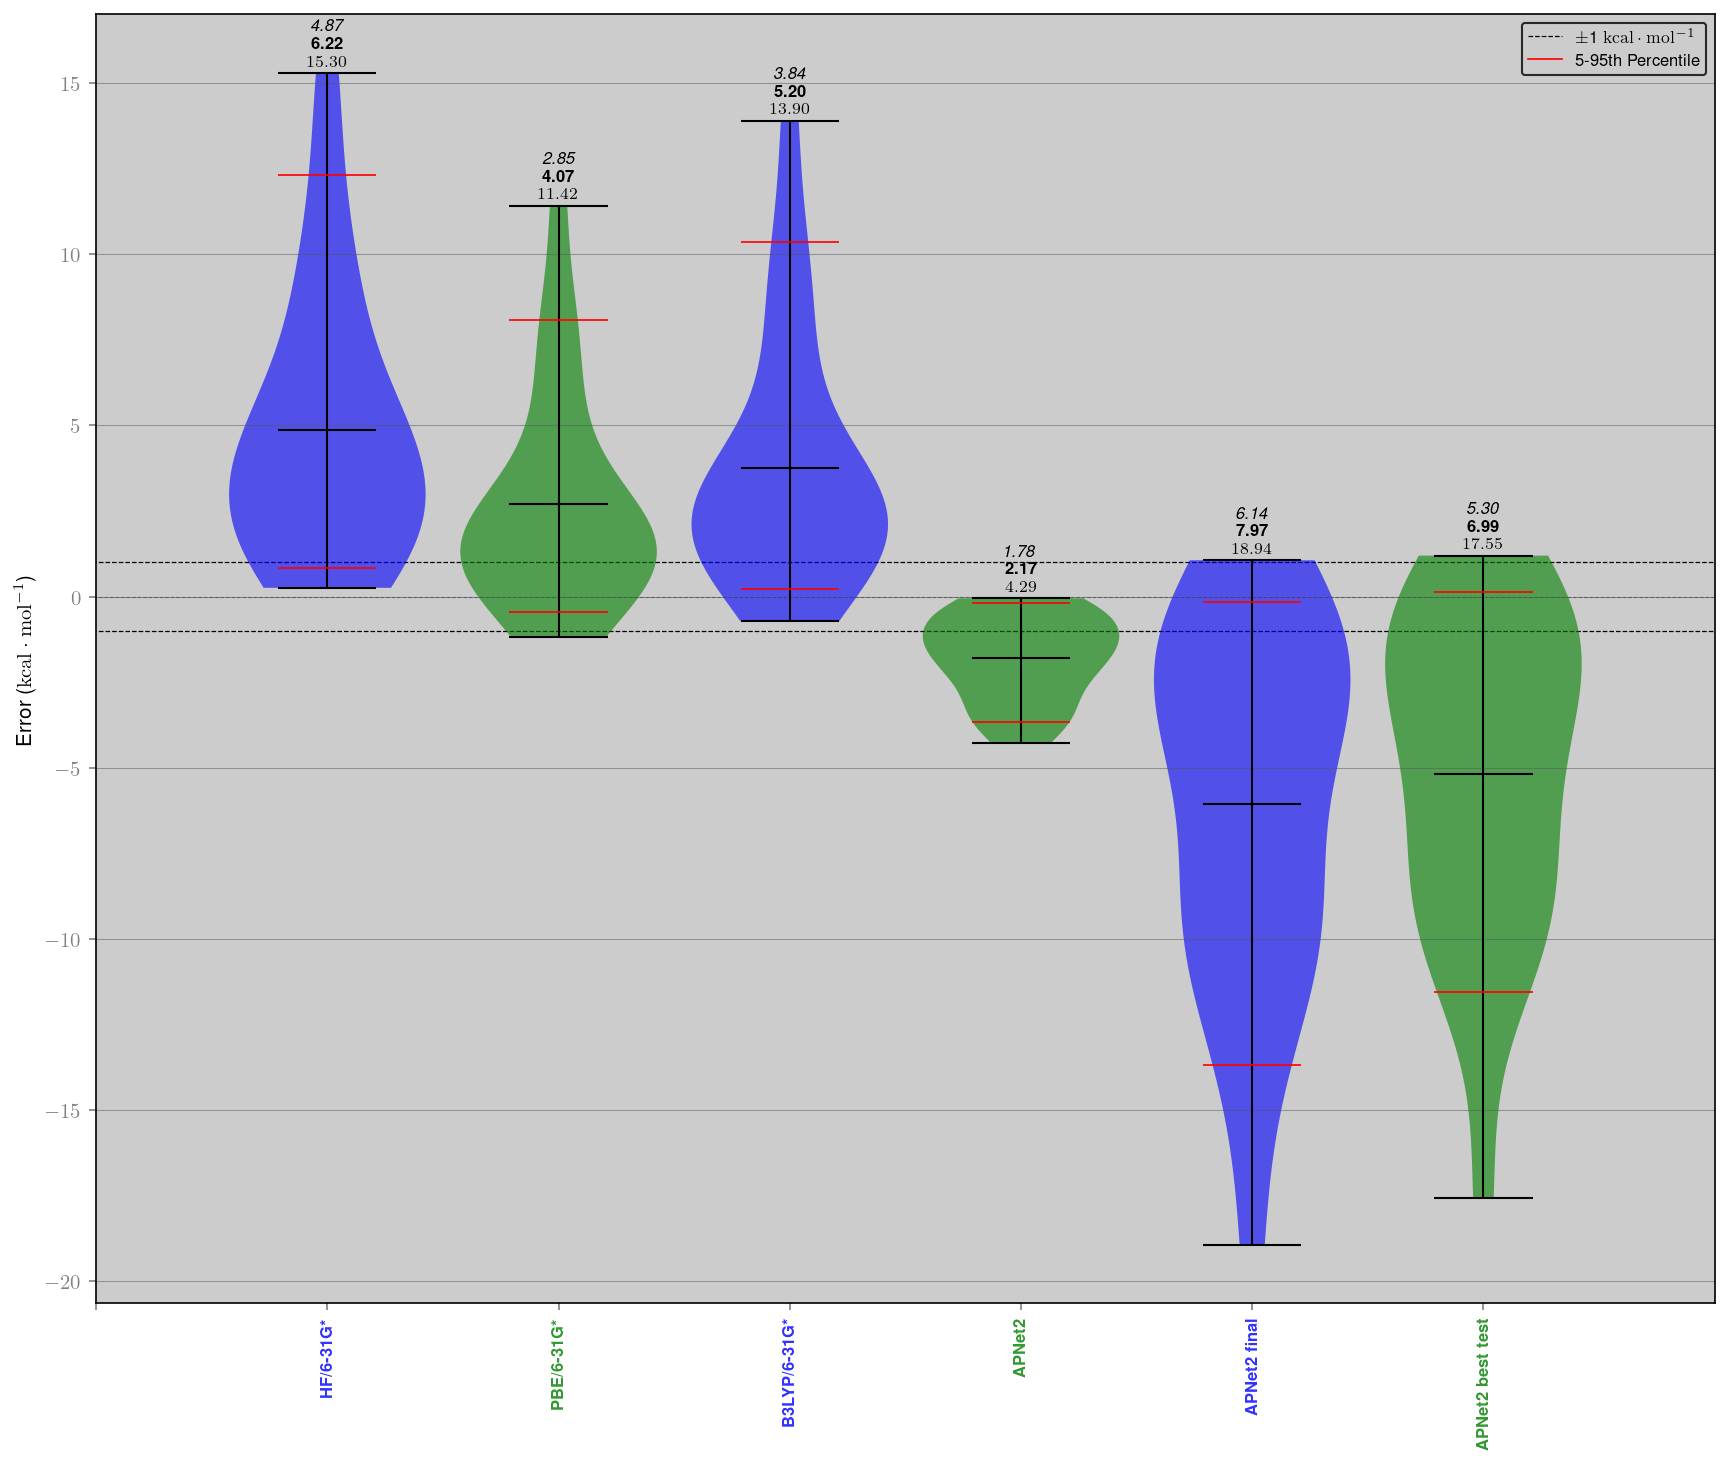

In [22]:
ap2_best_test = APNet2Model(
    atom_model=ap2.atom_model,
    pre_trained_model_path="apnet2_transfer_learning.pt",
)
print(ap2_best_test)

# AP-Net2 IE
apnet2_ies_predicted_final = ap2.predict_qcel_mols(
    mols=df_plot['qcel_molecule'].tolist(),
)
apnet2_ies_predicted_best_test = ap2_best_test.predict_qcel_mols(
    mols=df_plot['qcel_molecule'].tolist(),
)
print(apnet2_ies_predicted_final)
print(apnet2_ies_predicted_best_test)
df_plot['APNet2 final'] = np.sum(apnet2_ies_predicted_final, axis=1)
df_plot['APNet2 best test'] = np.sum(apnet2_ies_predicted_best_test, axis=1)
print(df_plot[['APNet2 final', 'APNet2 best test', 'reference', 'PBE/6-31G*']])
df_plot['APNet2 final error'] = (df_plot['APNet2 final'] - df_plot['reference']).astype(float)
df_plot['APNet2 best test error'] = (df_plot['APNet2 best test'] - df_plot['reference']).astype(float)

error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        "B3LYP/6-31G*": "B3LYP/6-31G* error",
        "APNet2": "APNet2 error",
        "APNet2 final": "APNet2 final error",
        "APNet2 best test": "APNet2 best test error",
    },
    output_filename="S22-IE-AP2.png",
    figure_size=(4, 4),
)

In [ ]:
# Be careful with this for it can corrupt running status...
# !ps aux | grep qcfractal | awk '{ print $2 }' | xargs kill -9

In [23]:
# Load in a dataset from a recent Sherrill work (Levels of SAPT II)
df_LoS = pd.read_pickle("./combined_df_subset_358.pkl")
print(df_LoS[['Benchmark', 'SAPT2+3(CCD)DMP2 TOTAL ENERGY aqz', 'MP2 IE atz', 'SAPT0 TOTAL ENERGY adz' ]])

# Limit to 100 molecules with maximum of 16 atoms to keep computational cost down
df_LoS['size'] = df_LoS['atomic_numbers'].apply(lambda x: len(x))
df_LoS = df_LoS[df_LoS['size'] <= 16]
df_LoS = df_LoS.sample(100, random_state=42, axis=0).copy()
df_LoS.reset_index(drop=True, inplace=True)
print(df_LoS['size'].describe())

# Create QCElemntal Molecules to generate the dataset
def qcel_mols(row):
    """
    Convert the row to a qcel molecule
    """
    atomic_numbers = [row['atomic_numbers'][row['monAs']], row['atomic_numbers'][row['monBs']]]
    coords = [row['coordinates'][row['monAs']], row['coordinates'][row['monBs']]]
    cm = [
        [row['monA_charge'], row['monA_multiplicity']],
        [row['monB_charge'], row['monB_multiplicity']],
     ]
    return tools.convert_pos_carts_to_mol(atomic_numbers, coords, cm)
df_LoS['qcel_molecule'] = df_LoS.apply(qcel_mols, axis=1)

     Benchmark  ... SAPT0 TOTAL ENERGY adz
0      -10.248  ...              -0.018254
1      -15.245  ...              -0.027620
2       -3.517  ...              -0.005920
3       -0.127  ...              -0.000192
4       -8.990  ...              -0.016209
..         ...  ...                    ...
353     -4.390  ...              -0.008013
354     -1.130  ...              -0.002090
355     -0.260  ...              -0.000503
356     -5.740  ...              -0.009757
357     -3.120  ...              -0.005630

[358 rows x 4 columns]
count    100.000000
mean      11.970000
std        2.750409
min        3.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       16.000000
Name: size, dtype: float64
0     Molecule(name='C2H4O4', formula='C2H4O4', hash...
1     Molecule(name='CH7NO', formula='CH7NO', hash='...
2     Molecule(name='C3H9NO2', formula='C3H9NO2', ha...
3     Molecule(name='C6H8O', formula='C6H8O', hash='...
4     Molecule(name='C4H8O4', formula='C4H8O4', h